# Prepare the Notebook

In [1]:
!pip install control
!git clone https://magiccvs.byu.edu/gitlab/control_book/control_book_public_solutions.git
#!cd control_book_public_solutions/;  git checkout Fall19_edits

     |████████████████████████████████| 256kB 8.8MB/s 
  Created wheel for control: filename=control-0.8.3-py2.py3-none-any.whl size=260982 sha256=9c135d7a72127a62c45c92625b37784affee43479a4b3d6635c637be08e20a0a
  Stored in directory: /root/.cache/pip/wheels/c2/d9/cc/90b28cb139a6320a3af2285428b6da87eee8d8920c78bb0223
Successfully built control
Cloning into 'control_book_public_solutions'...
remote: Enumerating objects: 2402, done.
remote: Counting objects: 100% (2402/2402), done.
remote: Compressing objects: 100% (1201/1201), done.
remote: Total 2402 (delta 1233), reused 2271 (delta 1143)
Receiving objects: 100% (2402/2402), 42.77 MiB | 13.39 MiB/s, done.
Resolving deltas: 100% (1233/1233), done.


In [0]:
import sys
import numpy as np
import control as c
from control.matlab import *
import matplotlib.pyplot as plt
from IPython.display import Latex
from IPython.display import Image

In [0]:
# Insert figures:
#basename = 'control_book_public_solutions/_images/'
#basename = './'
#img1 = Image(filename=basename+'figures_3/pid_complex_poles.png',width=1000)

# Part 4: Observer-based Control Design
## Chapter 12: Full State Feedback Control with Integral Control

### Lecture Notes

This notebook covers the material in Chapter 12 of the [text](http://controlbook.byu.edu/doku.php) in brief form, allowing you to make changes and manipulate the examples.  The goal is for this resource to help you bridge the gap between theory and the practical.

## 13.2 Summary of the Design Process - Observer Design
Since the chapter content up to this point is fairly analytical, we have skipped adding it here and instead, we present a new example along with the Design Study examples. 

A basic closed loop system with an observer is found in Figure 13-1 below: 

The design process for adding an integrator to state feedback can be summarized as follows.
Given the plant

$\dot{x} = Ax + Bu$

$y_r = C_rx,$

where we desire that $y_r$ tracks the reference $r$ using integral action using the controller

$u(t) = -Kx(t) - k_I\int_{-\infty}^t (r(\tau)-y_r(\tau))d\tau,$

with desired closed-loop gains at $p_1, p_2, \dots, p_n$, $p_I$.

> (1)  Augment the state evolution equation as

$\begin{pmatrix}\dot{x} \\ \dot{x}_I \end{pmatrix} = \begin{pmatrix} A & \mathbf{0} \\ -C_r & \mathbf{0} \end{pmatrix} \begin{pmatrix}x \\ x_I\end{pmatrix} + \begin{pmatrix}B \\ \mathbf{0}\end{pmatrix}u + \begin{pmatrix}\mathbf{0} \\ I\end{pmatrix}r,$

and let

$A_1 = \begin{pmatrix} A & \mathbf{0} \\ -C_r & \mathbf{0} \end{pmatrix} $

$B_1 = \begin{pmatrix}B \\ \mathbf{0}\end{pmatrix}$

> (2) Follow the pole placement procedure outlined in Chapter 11 to find $K_1$ that places the poles of the augmented system at $p_1, p_2, \dots, p_n$, and $p_I$.

> (3)  Find the gains $K$ and $k_I$ as

$K = K_1(1:n) $

$k_I = K_1(n+1).$


For reference, the process from Chapter 11 is

 * Step 1: Check controllability.  Compute the controllability matrix $\mathcal{C}_{A,B} = [B, AB, ..., A^{n-1}B]$ and then check that rank$(\mathcal{C}_{A,B}) = n$. 
 * Step 2: Place the poles at the desired locations using 'place' command.  (See text for full approach if that command is not available)
 * Step 3: Compkute the gain $k_r$ using $k_r = \frac{-1}{C_r(A - B K)^{-1} B}$  
 * Step 4: Simulate the system.  Check to see if the control design is valid and provides the desired performance. 

### Example System
The following is a quick example that is not in the book.

In [49]:
# System Model
A = np.array([[0.,1.,0.],[0.,0.,1.],[-1.,-5.,-6.]])
B = np.array([[0.],[0.],[1.]])
C = np.array([1., 0., 0.])
C = np.reshape(C,(1,3))
n = A.shape[0]

# Add the integrator: 
Ai1 = np.concatenate((A, np.zeros((A.shape[0],1))),1)
Ai2 = np.concatenate((-C,np.zeros((1,1))),1)
Ai = np.concatenate((Ai1,Ai2))
Bi = np.concatenate((B,np.zeros((1,1))))

# Desired poles (+1 for the integrator pole): 
tr = 1.
zeta = 0.707
wn = 2.2/tr  # natural frequency for position
des_char_poly = np.convolve([1., 2.*zeta*wn, wn**2.],
                            [1., 25., 150.])
dpoles = np.roots(des_char_poly)
#print('Poles: ',dpoles)

# Step 1: Check controllability: 
Ctrl = ctrb(Ai,Bi)
r = np.linalg.matrix_rank(Ctrl)
print('Rank of Controllability Matrix: ', r)
if r != 4:
    print("The system is not controllable!!")
else:
    # Step 2: Compute the gains: 
    Kp = acker(Ai, Bi, dpoles)
    K = Kp[0,0:3]
    Ki = Kp[0,-1]
    # Step 3: Compute k_r (for comparision only, below)
    kr = -1.0/(C*np.linalg.inv(A-B@K)@B)

print('K: ', K)
print('Ki:', Ki)
print('kr: ', kr)

Rank of Controllability Matrix:  4
K:  [[586.62   227.61    22.1108]]
Ki: -726.0000000000002
kr:  [[587.62]]


### Simulate the system

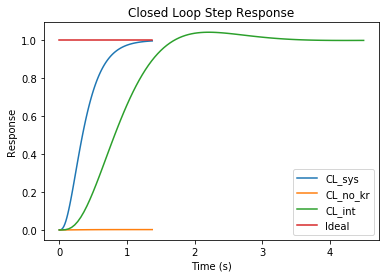

In [46]:
Acl = A - B@K
Bcl = B*kr
Ccl = C
Dcl = np.zeros((1,1))

Ael1 = np.concatenate((A - B @ K, -B * Ki),1)  # System dynamics
Ael3 = np.concatenate((-C, np.zeros((1, 1))), 1)  # Integrator State Dynamics
Ael = np.concatenate((Ael1, Ael3));
Bel = np.concatenate((B, np.ones((1, 1))))
Cel = np.concatenate((C, np.zeros((1, 1))), 1)
Del = np.zeros(1)

sys_cl = ss(Acl, Bcl, Ccl, Dcl)
sys_nokr = ss(Acl,B,Ccl, Dcl)
sys_cli = ss(Ael,Bel,Cel,Del)

y,t = step(sys_cl)
y2,t2 = step(sys_nokr)
y3,t3 = step(sys_cli)

fig, ax = plt.subplots()
ax.plot(t,y,label='CL_sys')
ax.plot(t2,y2,label='CL_no_kr')
ax.plot(t3,y3,label='CL_int')
ax.plot(t,np.ones_like(t),label='Ideal')
plt.title('Closed Loop Step Response')
plt.xlabel('Time (s)')
plt.ylabel('Response')
plt.legend()


Here you can see how $k_r$ makes the system arrive at the ideal (given perfect information).  Without $k_r$, the system does not arrive at the desired point.  The integrator gain comes at a cost, we slow down.  However, we are robust to disturbances and to modeling errors, as we will see. 

# Examples: Design Study A. Single Link Robot Arm
The objective of this problem is to implement a state feedback controller using the
full state. Start with the simulation files developed in Homework A.10.
> (a) Modify the state feedback solution developed in Homework A.11 to add an
integrator with anti-windup.

> (b) Add a disturbance to the system and allow the system parameters to change
up to 20%.

> (c) Tune the integrator pole (and other gains if necessary) to get good tracking
performance.

## A - (a) Closed Loop Poles

In [69]:
#%matplotlib tk 
sys.path.append('control_book_public_solutions/_a_arm/python/')
sys.path.append('control_book_public_solutions/_a_arm/python/hw10/')  # add homework directory
import armParam as P
import hw10.armParamHW10 as PP

# Desired poles: 
des_char_poly = np.array([1., 2.*PP.zeta*PP.wn, PP.wn**2.])
dpoles = np.roots(des_char_poly)
#Augment the desired poles: 
dpoles = np.concatenate((dpoles,np.array([-9.])))
print("Desired pole locations: ", dpoles)

Desired pole locations:  [-3.8885+3.8896745j -3.8885-3.8896745j -9.    +0.j       ]


## A - (b) State Space Model 

In [0]:
# System Model
# State Space Equations
# xdot = A*x + B*u
# y = C*x
A = np.array([[0.0, 1.0],
               [0.0, -1.0*P.b/P.m/(P.ell**2)]])
n = A.shape[0]
B = np.array([[0.0],
               [3.0/P.m/(P.ell**2)]])
C = np.array([[1.0, 0.0]])

# Add the integrator: 
Ai1 = np.concatenate((A, np.zeros((A.shape[0],1))),1)
Ai2 = np.concatenate((-C,np.zeros((1,1))),1)
Ai = np.concatenate((Ai1,Ai2))
Bi = np.concatenate((B,np.zeros((1,1))))

## A - (c) Controlability

In [66]:
Cntl = ctrb(Ai,Bi)
r = np.linalg.matrix_rank(Cntl)
print('Rank of Controllability Matrix: ', r, ', which should equal: ', n+1)

Rank of Controllability Matrix:  3 , which should equal:  3


## A - (d) Select Gains $K$ and $k_r$

In [71]:
Kp = acker(Ai, Bi, dpoles)
K = Kp[0,0:n]
Ki = Kp[0,-1]

kr = -1.0/(C*np.linalg.inv(A-B@K)@B)

print("Feedback gain K: ", K)
print("Integrator gain Ki: ", Ki)
print("Reference gain k_r: ", kr)

Feedback gain K:  [[1.503645   0.23498833]]
Integrator gain Ki:  -4.083750000000002
Reference gain k_r:  [[1.503645]]


## A - (e) Implement Control and Simulate
First, we are going to put the system through a quick closed loop check. 

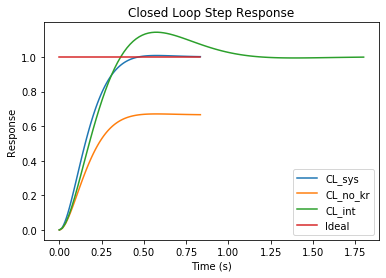

In [72]:
Acl = A - B@K
Bcl = B*kr
Ccl = C
Dcl = np.zeros((1,1))

Ael1 = np.concatenate((A - B @ K, -B * Ki),1)  # System dynamics
Ael3 = np.concatenate((-C, np.zeros((1, 1))), 1)  # Integrator State Dynamics
Ael = np.concatenate((Ael1, Ael3));
Bel = np.concatenate((B, np.ones((1, 1))))
Cel = np.concatenate((C, np.zeros((1, 1))), 1)
Del = np.zeros(1)

sys_cl = ss(Acl, Bcl, Ccl, Dcl)
sys_nokr = ss(Acl,B,Ccl, Dcl)
sys_cli = ss(Ael,Bel,Cel,Del)

y,t = step(sys_cl)
y2,t2 = step(sys_nokr)
y3,t3 = step(sys_cli)

fig, ax = plt.subplots()
ax.plot(t,y,label='CL_sys')
ax.plot(t2,y2,label='CL_no_kr')
ax.plot(t3,y3,label='CL_int')
ax.plot(t,np.ones_like(t),label='Ideal')
plt.title('Closed Loop Step Response')
plt.xlabel('Time (s)')
plt.ylabel('Response')
plt.legend()

### Run Simulation

In [73]:
#%matplotlib tk 
sys.path.append('control_book_public_solutions/_a_arm/python/')
sys.path.append('control_book_public_solutions/_a_arm/python/hw12/')  # add homework directory
import armParam as P
from hw3.armDynamics import armDynamics
from armController import armController
from hw2.signalGenerator import signalGenerator
from hw2.armAnimation import armAnimation
from hw2.dataPlotter import dataPlotter as armPlotData

kp:  0.45374999999999993
ki:  0.1
kd:  0.06665499999999998


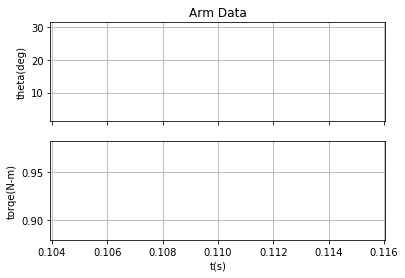

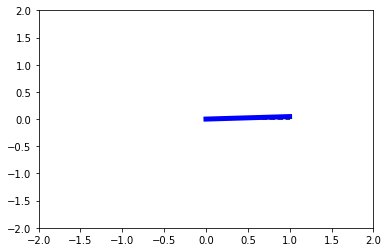

In [74]:
# instantiate arm, controller, and reference classes
arm = armDynamics(0.2)
ctrl = armController()
reference = signalGenerator(amplitude=30*np.pi/180.0, frequency=0.05)

# instantiate the simulation plots and animation
armDataPlot = armPlotData()
animation = armAnimation()

# set disturbance input
disturbance = 0.01

t = P.t_start  # time starts at t_start
while t < P.t_end:  # main simulation loop
    # Get referenced inputs from signal generators
    ref_input = reference.square(t)
    # Propagate dynamics in between plot samples
    t_next_plot = t + P.t_plot
    while t < t_next_plot: # updates control and dynamics at faster simulation rate
        u = ctrl.update(ref_input, arm.state)  # Calculate the control value
        sys_input = u + disturbance
        arm.update(sys_input)  # Propagate the dynamics
        t = t + P.Ts  # advance time by Ts
    # update animation and data plots
    animation.update(arm.state)
    armDataPlot.update(t, ref_input, arm.state, u)
    plt.pause(0.0001)  # the pause causes the figure to be displayed during the simulation

In [0]:
def postProcessPlot(dataPlot_arm):
  # Create a new figure, after the simulator has run, and display all the data: 
  fig, axes = plt.subplots(nrows=2, ncols=1)
  fig.tight_layout()
  plt.subplot(211)  
  plt.plot(dataPlot_arm.time_history, np.transpose([dataPlot_arm.theta_history, dataPlot_arm.theta_ref_history]))
  plt.title('Arm Data' )
  plt.ylabel('$\theta$ (deg)')  
  plt.xlabel('time (s)')
  plt.subplot(212)
  plt.plot(dataPlot_arm.time_history, dataPlot_arm.torque_history)
  plt.ylabel('Torque (N-m)')
  plt.xlabel('time (s)')

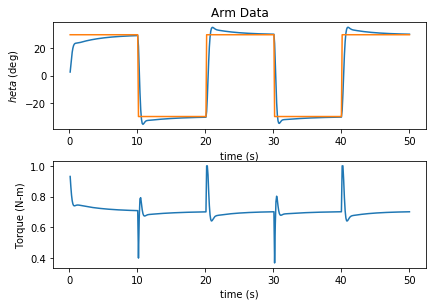

In [76]:
postProcessPlot(armDataPlot)

# Examples - Design Study B: Inverted Pendulum
The objective of this problem is to implement a state feedback controller using the
full state. Start with the simulation files developed in Homework A.10.
> (a) Modify the state feedback solution developed in Homework B.11 to add an
integrator with anti-windup.

> (b) Add a disturbance to the system and allow the system parameters to change
up to 20%.

> (c) Tune the integrator pole (and other gains if necessary) to get good tracking
performance.

In [0]:
%reset -f
# Design Problem B : Pendulum
# Start fresh, global namespace is clear: 
import sys
import numpy as np
import control as c
from control.matlab import *
import matplotlib.pyplot as plt
from IPython.display import Latex
from IPython.display import Image

In [2]:
#%matplotlib tk 
sys.path.append('control_book_public_solutions/_B_pendulum/python')
sys.path.append('control_book_public_solutions/_B_pendulum/python/hw11/')  # add homework directory
import pendulumParam as P
import hw10.pendulumParamHW10 as PP

DC_gain 1.8754253767622748
kp_th:  -26.24319727891157
kd_th:  -3.1478333333333333
kp_z:  -0.06189092517559949
ki_z:  -0.005
kd_z:  -0.1506408552390715


## B - (a)-(d) Design and build the controller


In [3]:
# gain calculation
wn_th = 2.2/PP.tr_th  # natural frequency for angle
wn_z = 2.2/PP.tr_z  # natural frequency for position
des_char_poly = np.convolve([1, 2*PP.zeta_z*wn_z, wn_z**2],
                            [1, 2*PP.zeta_th*wn_th, wn_th**2])
des_poles = np.roots(des_char_poly)
# Add pole for the integrator: 
des_poles = np.concatenate((des_poles,np.array([-10.])))

A = np.array([[0.0, 0.0, 1.0, 0.0],
               [0.0, 0.0, 0.0, 1.0],
               [0.0, -3*P.m1*P.g/4/(.25*P.m1+P.m2),
                -P.b/(.25*P.m1+P.m2), 0.0],
               [0.0, 3*(P.m1+P.m2)*P.g/2/(.25*P.m1+P.m2)/P.ell,
                3*P.b/2/(.25*P.m1+P.m2)/P.ell, 0.0]])
B = np.array([[0.0],
               [0.0],
               [1/(.25*P.m1+P.m2)],
               [-3.0/2/(.25*P.m1+P.m2)/P.ell]])

C = np.array([[1.0, 0.0, 0.0, 0.0],
               [0.0, 1.0, 0.0, 0.0]])
Cr = np.array([[1.0, 0.0, 0.0, 0.0]])

n = A.shape[0]

# Add the integrator: 
Ai1 = np.concatenate((A, np.zeros((n,1))),1)
Ai2 = np.concatenate((-Cr,np.zeros((1,1))),1)
Ai = np.concatenate((Ai1,Ai2))
Bi = np.concatenate((B,np.zeros((1,1))))

# Compute the gains if the system is controllable
if np.linalg.matrix_rank(ctrb(Ai, Bi)) != n+1:
    print("The system is not controllable")
else:
    Kp = acker(Ai, Bi, des_poles)
    K = Kp[0,0:n]
    Ki = Kp[0,-1]
    kr = -1.0/(Cr*np.linalg.inv(A-B@K)@B)

print('K: ', K)
print('Ki: ', Ki)
print('kr: (for comparison) ', kr)

K:  [[ -1.96016428 -33.29692828  -3.19284133  -4.86439711]]
Ki:  0.5641572247391266
kr: (for comparison)  [[-1.96016428]]


## B - (e) Implement Control and Simulate
Again, we will form a closed loop system and simulate a step and then do the full simulation. 

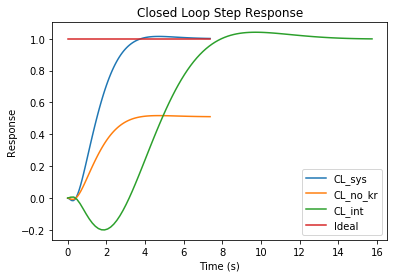

In [4]:
Acl = A - B@K
Bcl = B*kr
Ccl = Cr
Dcl = np.zeros((1,1))

Ael1 = np.concatenate((A - B @ K, -B * Ki),1)  # System dynamics
Ael3 = np.concatenate((-Cr, np.zeros((1, 1))), 1)  # Integrator State Dynamics
Ael = np.concatenate((Ael1, Ael3));
Bel = np.concatenate((B, np.ones((1, 1))))
Cel = np.concatenate((Cr, np.zeros((1, 1))), 1)
Del = np.zeros(1)

sys_cl = ss(Acl, Bcl, Ccl, Dcl)
sys_nokr = ss(Acl,-B,Ccl, Dcl)
sys_cli = ss(Ael,Bel,Cel,Del)

y,t = step(sys_cl)
y2,t2 = step(sys_nokr)
y3,t3 = step(sys_cli)

fig, ax = plt.subplots()
ax.plot(t,y,label='CL_sys')
ax.plot(t2,y2,label='CL_no_kr')
ax.plot(t3,y3,label='CL_int')
ax.plot(t,np.ones_like(t),label='Ideal')
plt.title('Closed Loop Step Response')
plt.xlabel('Time (s)')
plt.ylabel('Response')
plt.legend()

### Simulate the System

K:  [[ -3.38635374 -28.80421387  -3.31475286  -4.39347595]]
kr:  [[-3.38635374]]


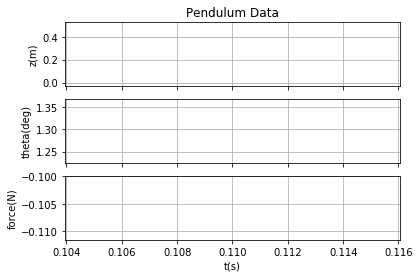

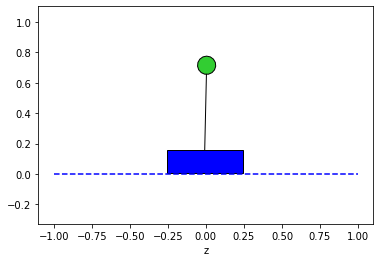

In [5]:
#%matplotlib tk 
import pendulumParam as P
from hw3.pendulumDynamics import pendulumDynamics
from pendulumController import pendulumController
from hw2.signalGenerator import signalGenerator
from hw2.pendulumAnimation import pendulumAnimation
from hw2.dataPlotter import dataPlotter as pendulumPlotData


pendulum = pendulumDynamics(0.2)
ctrl = pendulumController() 
reference = signalGenerator(amplitude=0.5, frequency=0.02)

# instantiate the simulation plots and animation
pendDataPlot = pendulumPlotData()
animation = pendulumAnimation()

t = P.t_start  # time starts at t_start
while t < P.t_end:  # main simulation loop
    # Get referenced inputs from signal generators
    ref_input = reference.square(t)
    # Propagate dynamics in between plot samples
    t_next_plot = t + P.t_plot
    while t < t_next_plot: # updates control and dynamics at faster simulation rate
        u = ctrl.update(ref_input, pendulum.state)  # Calculate the control value        
        pendulum.update(u)  # Propagate the dynamics
        t = t + P.Ts  # advance time by Ts
    # update animation and data plots
    animation.update(pendulum.state)
    pendDataPlot.update(t, ref_input, pendulum.state, u)
    #dataPlot.update(t, [0.0,0.0], pendulum.state, u)
    plt.pause(0.0001)  # the pause causes the figure to be displayed during the simulation

In [0]:
def postProcessPlotPendulum(dataPlot_pen):
  # Create a new figure, after the simulator has run, and display all the data: 
  fig, axes = plt.subplots(nrows=3, ncols=1)
  fig.tight_layout()
  plt.subplot(311)  
  plt.plot(dataPlot_pen.time_history, np.transpose([dataPlot_pen.z_history, dataPlot_pen.zref_history]))
  plt.title('Pendulum Data' )
  plt.ylabel('$z$ (deg)')  
  plt.xlabel('time (s)')
  plt.subplot(312)  
  plt.plot(dataPlot_pen.time_history, np.transpose(dataPlot_pen.theta_history))
  plt.ylabel('$\theta$ (deg)')  
  plt.xlabel('time (s)')
  plt.subplot(313)
  plt.plot(dataPlot_pen.time_history, dataPlot_pen.Force_history)
  plt.ylabel('Force (N)')
  plt.xlabel('time (s)')

**Note**: If you get an error in the cell below, something like  "*AttributeError: 'dataPlotter' object has no attribute 'z_history'*" , you need to restart your runtime and run the first couple cells and then come down and run this example, under "Simulate the System".  I have not been able to get the different examples to run under the same runtime. I think that there are too many similarly named components.  


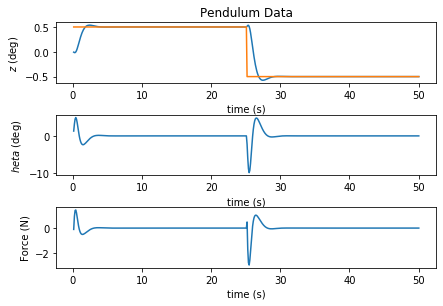

In [7]:
postProcessPlotPendulum(pendDataPlot)

# Examples - Design Study C: Satellite Control
The objective of this problem is to implement a state feedback controller using the
full state. Start with the simulation files developed in Homework C.10.

> (a) Modify the state feedback solution developed in Homework C.11 to add an
integrator with anti-windup.

> (b) Add a disturbance to the system and allow the system parameters to change
up to 20%.

> (c) Tune the integrator pole (and other gains if necessary) to get good tracking
performance.

In [0]:
%reset -f
# Design Problem C
# Start fresh, global namespace is clear: 
import sys
import numpy as np
import control as c
from control.matlab import *
import matplotlib.pyplot as plt
from IPython.display import Latex
from IPython.display import Image

## C - (a)-(d) Design the Controller



In [0]:
#%matplotlib tk 
sys.path.append('control_book_public_solutions/_C_satellite/python/')
sys.path.append('control_book_public_solutions/_C_satellite/python/hw11')
import satelliteParam as P

In [3]:
# tuning parameters
wn_th = 0.6
wn_phi = 1.1    # rise time for angle
zeta_phi = 0.707  # damping ratio position
zeta_th = 0.707  # damping ratio angle

# State Space Equations
# xdot = A*x + B*u
# y = C*x
A = np.array([[0.0, 0.0,               1.0,      0.0],
               [0.0, 0.0,               0.0,      1.0],
               [-P.k/P.Js, P.k/P.Js, -P.b/P.Js, P.b/P.Js],
               [P.k/P.Jp, -P.k/P.Jp, P.b/P.Jp, -P.b/P.Jp]])

B = np.array([[0.0],
               [0.0],
               [1.0/P.Js],
               [0.0]])

C = np.array([[1.0, 0.0, 0.0, 0.0],
               [0.0, 1.0, 0.0, 0.0]])
Cr = np.array([[1.0, 0.0, 0.0, 0.0]])

n = A.shape[0]

# Add the integrator: 
Ai1 = np.concatenate((A, np.zeros((n,1))),1)
Ai2 = np.concatenate((-Cr,np.zeros((1,1))),1)
Ai = np.concatenate((Ai1,Ai2))
Bi = np.concatenate((B,np.zeros((1,1))))

# gain calculation
des_char_poly = np.convolve([1, 2*zeta_th*wn_th, wn_th**2],
                            [1, 2*zeta_phi*wn_phi, wn_phi**2])
des_poles = np.roots(des_char_poly)
# Add desired pole for integrator: 
des_poles = np.concatenate((des_poles,np.array([-1.])))

# Compute the gains if the system is controllable
if np.linalg.matrix_rank(ctrb(Ai, Bi)) != n+1:
    print("The system is not controllable")
else:
    Kp = acker(Ai, Bi, des_poles)
    dpoles_old = des_poles[0:n]
    Kold = acker(A,B,dpoles_old)
    K = Kp[0,0:n]
    Ki = Kp[0,-1]
    kr = -1.0/(Cr @ np.linalg.inv(A - B @ Kold) @ B)

print('K: ', K)
print('Ki: ', Ki)
print('kr (for comparisions): ', kr)


K:  [[23.9895512 38.5740488 16.719     14.830112 ]]
Ki:  -14.519999999999987
kr (for comparisions):  [[14.52]]


## C - (e) Simulate the System
First set up a simple closed loop linear system to test out the control. 


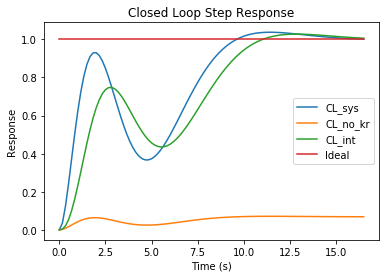

In [4]:
Acl = A - B@Kold
Bcl = B*kr
Ccl = Cr
Dcl = np.zeros((1,1))

Ael1 = np.concatenate((A - B @ K, -B * Ki),1)  # System dynamics
Ael3 = np.concatenate((-Cr, np.zeros((1, 1))), 1)  # Integrator State Dynamics
Ael = np.concatenate((Ael1, Ael3));
Bel = np.concatenate((B, np.ones((1, 1))))
Cel = np.concatenate((Cr, np.zeros((1, 1))), 1)
Del = np.zeros(1)

sys_cl = ss(Acl, Bcl, Ccl, Dcl)
sys_nokr = ss(Acl,B,Ccl, Dcl)
sys_cli = ss(Ael,Bel,Cel,Del)

y,t = step(sys_cl)
y2,t2 = step(sys_nokr)
y3,t3 = step(sys_cli)

fig, ax = plt.subplots()
ax.plot(t,y,label='CL_sys')
ax.plot(t2,y2,label='CL_no_kr')
ax.plot(t3,y3,label='CL_int')
ax.plot(t,np.ones_like(t),label='Ideal')
plt.title('Closed Loop Step Response')
plt.xlabel('Time (s)')
plt.ylabel('Response')
plt.legend()

K:  [[11.1458268  3.3741732 11.719     36.3246   ]]
kr:  [[14.52]]


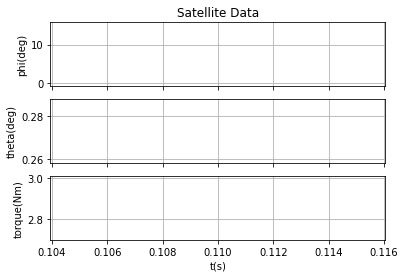

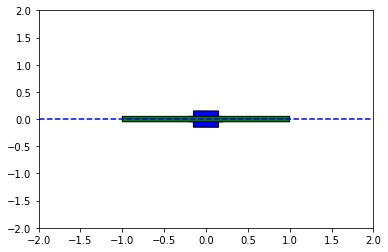

In [5]:
#%matplotlib tk 
sys.path.append('control_book_public_solutions/_C_satellite/python/')
sys.path.append('control_book_public_solutions/_C_satellite/python/hw11')
import satelliteParam as P
from hw3.satelliteDynamics import satelliteDynamics
from satelliteController import satelliteController
from hw2.signalGenerator import signalGenerator
from hw2.satelliteAnimation import satelliteAnimation
from hw2.dataPlotter import dataPlotter as satellitePlotData
P.k = 0.1

# instantiate satellite, controller, and reference classes
satellite = satelliteDynamics(0.1)
ctrl = satelliteController()
reference = signalGenerator(amplitude=15.0*np.pi/180.0, frequency=0.02)

# set disturbance input
disturbance = 0.50

# instantiate the simulation plots and animation
satDataPlot = satellitePlotData()
animation = satelliteAnimation()

t = P.t_start  # time starts at t_start
while t < P.t_end:  # main simulation loop
    # Get referenced inputs from signal generators
    ref_input = reference.square(t)
    # Propagate dynamics in between plot samples
    t_next_plot = t + P.t_plot
    while t < t_next_plot:  # updates control and dynamics at faster simulation rate
        tau = ctrl.update(ref_input, satellite.state)  # Calculate the control value
        sys_input = tau+disturbance  # input to plant is control input + disturbance (formatted as a list)
        satellite.update(sys_input)  # Propagate the dynamics with disturbance input
        t = t + P.Ts  # advance time by Ts
    # update animation and data plots
    animation.update(satellite.state)
    satDataPlot.update(t, ref_input, satellite.state, tau)
    plt.pause(0.0001)  # the pause causes the figure to be displayed during the simulation

In [0]:
def postProcessPlotSatellite(dataPlot_sat):
  # Create a new figure, after the simulator has run, and display all the data: 
  fig, axes = plt.subplots(nrows=3, ncols=1)
  fig.tight_layout()
  plt.subplot(311)  
  plt.plot(dataPlot_sat.time_history, np.transpose([dataPlot_sat.phi_history, dataPlot_sat.phi_ref_history]))
  plt.title('Satellite Data' )
  plt.ylabel('$\phi$ (deg)')  
  plt.xlabel('time (s)')
  plt.subplot(312)  
  plt.plot(dataPlot_sat.time_history, np.transpose(dataPlot_sat.theta_history))
  plt.ylabel('$\theta$ (deg)')  
  plt.xlabel('time (s)')
  plt.subplot(313)
  plt.plot(dataPlot_sat.time_history, dataPlot_sat.torque_history)
  plt.ylabel('Torque (Nm)')
  plt.xlabel('time (s)')

**Note**  If you get an error like this: *AttributeError: 'dataPlotter' object has no attribute 'phi_history'*  You are trying to run multiple Design Study problems in one session. Right now there is a known bug for this (probably too-similar naming convention and no namespaces).  Work around is to restart your instance, run the first couple of cells that import things, then come down here and run the Satellite simulation.  Then things should work out just fine. 

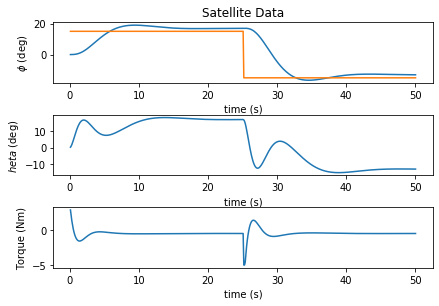

In [7]:
postProcessPlotSatellite(satDataPlot)